In [1]:
# test new classes
from echolab2.instruments import EK80
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from glob import glob
import warnings
warnings.filterwarnings('ignore')
import svf as svf

%load_ext autoreload
%autoreload 2

# Version 1: Build a multi-frequency svf_results object

In [6]:
# STEP 1: Reasd in raw files
# If you want to include the CW data in the files (specific to current project), set add_cw=True in the inputs and svf_results call
file_dir = 'D:/FMCW/svf/data/fish/' # set the input file directory
raw_files = glob(file_dir+'*.raw')

ek80 = EK80.EK80() # initiate the EK80 class in pyecholab
ek80.read_raw(raw_files, frequencies=[38000]) # read in all the raw files in that directory or a subset
print('Current ek80 object containins',ek80.n_pings,'pings')

Current ek80 object containins 17677 pings


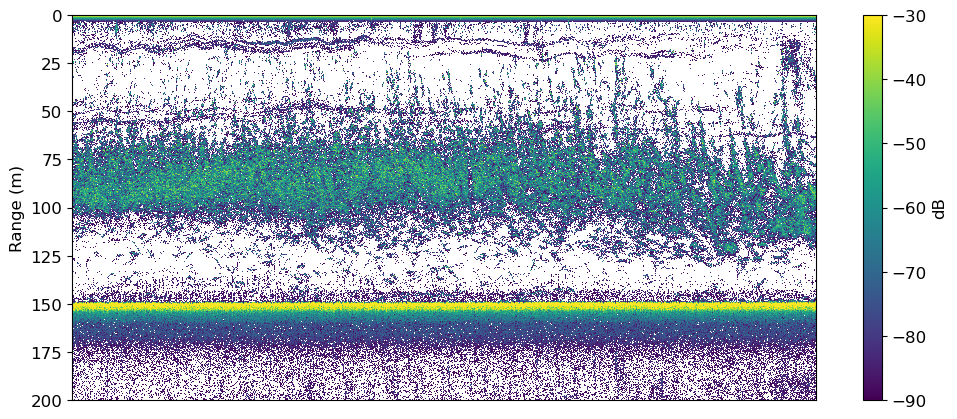

In [38]:
d = ek80.get_channel_data()['WBT 978217-15 ES38-7_2'][0]

import matplotlib.colors as colors
test = colors.Colormap('viridis')
test = test.set_under('w')

from matplotlib.pyplot import figure, show, subplots_adjust, get_cmap
from echolab2.instruments import EK80
from echolab2.plotting.matplotlib import echogram

%matplotlib inline

f = 38000
d_sv = d.get_Sv()
plt.rcParams['font.size'] = 12

fig_1 = figure(figsize=(12,5))#,dpi=150)
eg = echogram.Echogram(fig_1, d_sv,threshold=[-90,-30],cmap='viridis')
eg.cmap.set_under('w')
eg.axes.grid(False)
eg.axes.set_ylim(0,200)
eg.axes.invert_yaxis()
eg.axes.set_xticks([])
eg.axes.set_xlabel('')
eg.axes.set_ylabel('Range (m)')
eg.add_colorbar(fig=fig_1)
show()


In [16]:
frequencies = [38000,70000,120000,200000] # set the frequencies to read in
exclude_above = 5 # this can be a pyEcholab line object or an int/flt, I'm giving it 5 m as a cutoff for the whole file
exclude_below = 'xyz' # I'm going to grab the xyz files and use the line object in the file for the bottom

svf_results = svf.svf()
svt_results_fm = svf.svt()
svt_results_cw = svf.svt(pulse='CW')

# Define the frequency and channel id
for freq in frequencies:
    inputs = svf.inputs(ek80,freq,add_cw=True,frequency_resolution=None) # Set up the input object
    inputs.get_bottom_xyz() # Get the bottom line from the xyz files and add it to our inputs
    svf_results.calc_sample_Svf(inputs,exclude_above_line=5,exclude_below_line='xyz') # Calculate the by-sample svf
    svf_results.grid_Svf(inputs,interval_length=50, layer_thickness=5) # grid the svf
    svf_results.get_noise(inputs) # add the noise estimate

XYZ bottom line does not match length of Sv data, proceed with caution
Padding XYZ bottom line to match Sv data
XYZ bottom line does not match length of Sv data, proceed with caution
Padding XYZ bottom line to match Sv data
XYZ bottom line does not match length of Sv data, proceed with caution
Padding XYZ bottom line to match Sv data


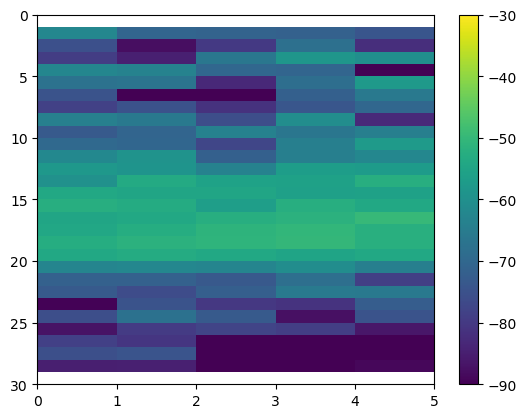

In [17]:
# Take a quick look at the results
plt.pcolormesh(svf.pMean(svf_results.Sv_grid[38000],axis=2).T,vmin=-90, vmax=-30)
plt.ylim(0,150/svf_results.g.layer_thickness)
plt.gca().invert_yaxis()
plt.colorbar()

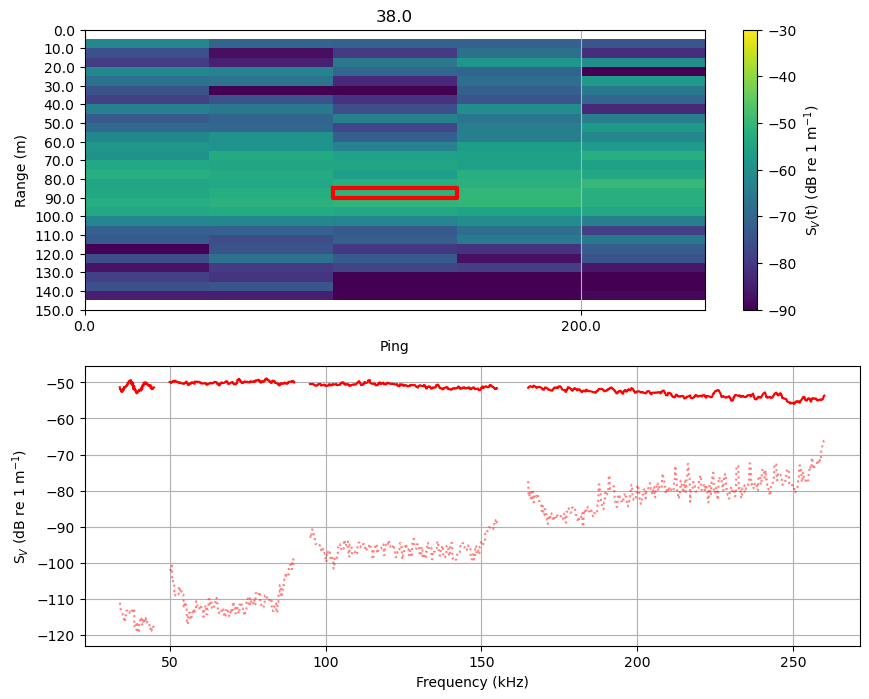

In [24]:
interval =[2]#[7,8,10] # These are 0-indexed
layer  = [17]#[3,17,25] # These are 0-indexed
import matplotlib as mpl
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["r", "orange", "purple"]) 

maxRange=150

# I can iterate tyhrough each of these as well and maybe put all the frequencies on one plot
e_freq = 38000

fig = plt.figure(figsize=(10,8))
plt.subplot(211)
plt.pcolormesh(svf.pMean(svf_results.Sv_grid[e_freq],axis=2).T,vmin=-90, vmax=-30)

plt.title('Average of S$_{V}$(f) by cell')
plt.ylabel('Range (m)')
plt.xlabel('Ping')
plt.title(e_freq/1000)
plt.gca().set_xticks(range(len(svf_results.g.interval_edges))[:-1:4])
plt.gca().set_xticklabels(svf_results.g.interval_edges[:-1:4])
plt.gca().set_yticks(range(len(svf_results.g.layer_edges))[:-1:2])
plt.gca().set_yticklabels(svf_results.g.layer_edges[:-1:2])
plt.ylim(0,maxRange/svf_results.g.layer_thickness)
plt.gca().invert_yaxis()

box_colors = []
for interval_iter,layer_iter in zip(interval,layer):
    p = plt.plot([interval_iter,interval_iter+1,interval_iter+1,interval_iter,interval_iter],
             [layer_iter,layer_iter, layer_iter+1, layer_iter+1,layer_iter],linewidth=3)
    box_colors.append(p[0].get_color())
plt.grid(axis='x')
plt.colorbar(label='S$_{V}$(t) (dB re 1 m$^{-1}$)')

plt.subplot(212)
for interval_iter,layer_iter,c in zip(interval,layer,box_colors):
    for freq in frequencies:
        plt.plot(svf_results.frequency[freq]/1000, svf_results.Sv_grid[freq][interval_iter][layer_iter],color=c)
        plt.plot(svf_results.frequency[freq]/1000, svf_results.Sv_noise[freq][layer_iter],linestyle=':',color=c,alpha=0.5)
plt.xlabel('Frequency (kHz)')  
plt.ylabel('S$_{V}$ (dB re 1 m$^{-1}$)') 
plt.grid()

# Version 2: Export Sv(f), read, and plot

In [36]:
raw_files

['D:/FMCW/svf/data/fish\\DY2207_EK80-D20220706-T112414.raw',
 'D:/FMCW/svf/data/fish\\DY2207_EK80-D20220706-T113132.raw']

In [37]:
# STEP 1: User Inputs
file_dir = 'D:/FMCW/svf/data/fish/' # set the input file directory
raw_files = glob(file_dir+'*.raw')[2:4]
frequencies = [38000,70000,120000,200000] # set the frequencies to read in
exclude_above_line = 5 # this can be a pyEcholab line object or an int/flt, I'm giving it 5 m as a cutoff for the whole file
exclude_below_line = 'xyz' # I'm going to grab the xyz files and use the line object in the file for the bottom


ek80 = EK80.EK80() # initiate the EK80 class in pyecholab
ek80.read_raw(raw_files) # read in the raw files

for freq in frequencies:
    # STEP 2: Set up our inputs
    inputs = svf.inputs(ek80,freq,add_cw=False,frequency_resolution=None) # Set up the input object
    inputs.get_bottom_xyz() # Get the bottom line from the xyz files and add it to our inputs

    # STEP 3: Calculate the sample Sv(f) and grid it
    svf_results.calc_sample_Svf(inputs,exclude_above_line=5,exclude_below_line='xyz') # Calculate the by-sample svf
    svf_results.grid_Svf(inputs,interval_length=50, layer_thickness=5) # grid the svf
    svf_results.get_noise(inputs) # add the noise estimate

    # To save the gridded data, tell it what frequency to use and where to put the file
    svf.write_grid_to_csv(svf_results,freq,output_dir='D:/FMCW/svf/cleanCopy/test/')

XYZ bottom line does not match length of Sv data, proceed with caution
Padding XYZ bottom line to match Sv data
XYZ bottom line does not match length of Sv data, proceed with caution
Padding XYZ bottom line to match Sv data


In [39]:
import os
import numpy as np
import pandas as pd

def makeArray(text):
    return np.fromstring(text,sep=';')


output_dir = 'D:/FMCW/svf/cleanCopy/test/'

file_dates = np.unique([file.split('-')[0] for file in [os.path.basename(file) for file in glob(output_dir+'*.csv')]])[:2]

all_data = []
for date in file_dates:
    output_files = glob(output_dir+date+'*.csv')
    cur_date = [pd.read_csv(file) for file in output_files]
    cur_date = pd.concat(cur_date)
    cur_date['fileset'] = date
    cur_date['frequency'] = cur_date['frequency'].apply(makeArray)
    cur_date['mean_Sv'] = cur_date['mean_Sv'].apply(makeArray)
    cur_date['SNR'] = cur_date['SNR'].apply(makeArray)
    cur_date['mean_Sv_ave'] = cur_date['mean_Sv'].apply(svf.pMean)
    cur_date['SNR_ave'] = cur_date['SNR'].apply(svf.pMean)
    all_data.append(cur_date)
all_data = pd.concat(all_data)



Text(0, 0.5, 'S$_{V}$ (dB re 1 m$^{-1}$)')

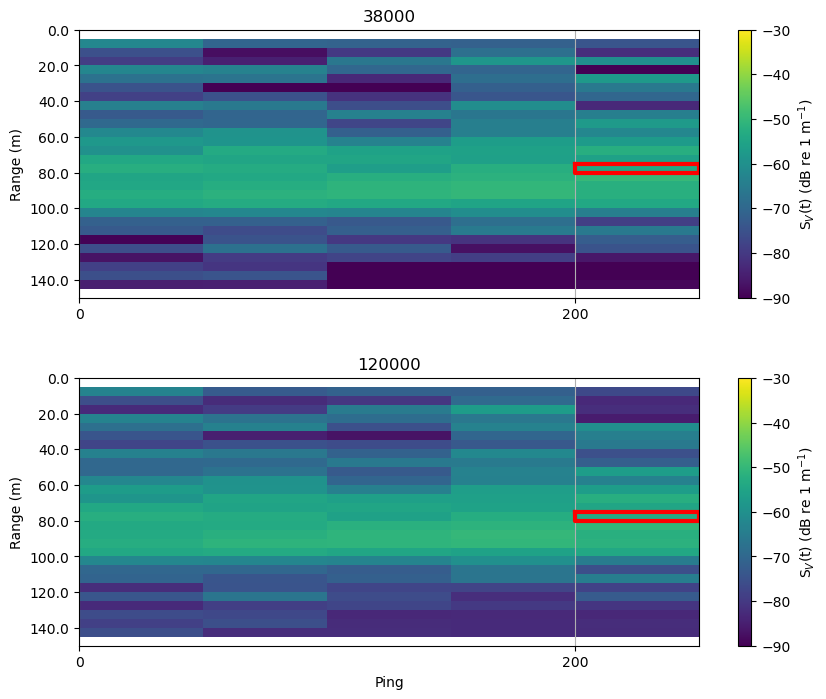

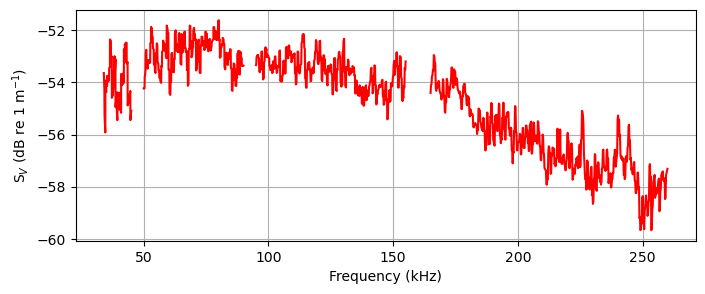

In [54]:
interval = 5 # Start at 1
layer = 16 # Start at 1
maxRange=150

frequencies = [38000,120000]

fig = plt.figure(figsize=(10,4*len(frequencies)))

for f in range(len(frequencies)):
    sv_mean_hold = np.full((len(all_data.interval.unique()),len(all_data.layer.unique())),np.nan)

    for iter_interval in all_data.interval.unique():
        for iter_layer in all_data.layer.unique():
            sv_mean_hold[iter_interval-1,iter_layer-1] = svf.pMean(all_data[(all_data.interval==iter_interval) & (all_data.layer==iter_layer)&(all_data.channel==frequencies[f])].mean_Sv.values[0])

    plt.subplot(len(frequencies),1,f+1)
    plt.pcolormesh(sv_mean_hold.T,vmin=-90,vmax=-30)
    
    


    p = plt.plot([interval-1,interval,interval,interval-1,interval-1],
            [layer-1,layer-1, layer, layer,layer-1],linewidth=3,color='r')

    plt.title(str(frequencies[f]))
    plt.ylabel('Range (m)')
    plt.gca().set_yticks(range(len(all_data.layer_start.unique()))[::4])
    plt.gca().set_yticklabels(all_data.layer_start.unique()[::4])
    plt.gca().set_xticks(range(len(all_data.ping_start.unique()))[::4])
    plt.gca().set_xticklabels(all_data.ping_start.unique()[::4])
    plt.grid(axis='x')
    plt.ylim(0,maxRange/svf_results.g.layer_thickness)
    plt.gca().invert_yaxis()
    plt.colorbar(label='S$_{V}$(t) (dB re 1 m$^{-1}$)')

    if f == len(frequencies)-1:
        plt.xlabel('Ping')

    plt.subplots_adjust(wspace=0.3,hspace=0.3)

fig = plt.figure(figsize=(8,3))
f = all_data[(all_data.interval == interval)&(all_data.layer == layer)].sort_values('channel').frequency.values
sv = all_data[(all_data.interval == interval)&(all_data.layer == layer)].sort_values('channel').mean_Sv.values

for iter_f,iter_sv in zip(f,sv):
    plt.plot(iter_f/1000,iter_sv,'r')
plt.grid()
plt.xlabel('Frequency (kHz)')
plt.ylabel('S$_{V}$ (dB re 1 m$^{-1}$)')